# Setup

## Packages

In [1]:
# Data analysis
import scanpy as sc
import numpy as np
import pandas as pd
import decoupler as dc

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patches
from matplotlib.path import Path

## Functions

### scatterplots

#### shuffled embedding

Wrapper for sc.pl.embedding with a few changes in parameters and shuffled order of cells.

In [2]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    """
    Plot a shuffled embedding of single-cell data using Scanpy.

    This function randomly permutes the order of cells before plotting
    an embedding (e.g., UMAP, t-SNE, PCA) to avoid overplotting biases.
    It serves as a wrapper around `scanpy.pl.embedding` with the cell
    order randomized for visualization purposes.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix (from `scanpy`), where observations are cells.
    basis : str, default="X_umap"
        The embedding to plot. Must be a key in `adata.obsm` (e.g., "X_umap", "X_pca").
    legend_fontsize : int, default=12
        Font size for the legend.
    legend_fontoutline : int, default=3
        Width of the outline around legend text.
    add_outline : bool, default=False
        Whether to add an outline around points.
    frameon : bool, default=False
        Whether to draw a frame around the plot.
    size : float, optional
        Point size for cells. If not provided, it is set to
        `1_000_000 / n_obs` for automatic scaling.
    show : bool, default=False
        Whether to display the plot immediately.
    *args :
        Additional positional arguments passed to `scanpy.pl.embedding`.
    **kwargs :
        Additional keyword arguments passed to `scanpy.pl.embedding`.

    Notes
    -----
    - The random seed is fixed (`np.random.seed(0)`) to ensure reproducibility
      of the shuffle.
    - Shuffling helps prevent high-density clusters from always being plotted
      on top, which can obscure less dense regions.

    Returns
    -------
    None
        The function produces a plot but does not return an object.
    """

    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 1000000 / adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

### barplots

Function to generate the normalized DataFrame for a barplot.

In [3]:
def get_dataframe_barplot(
    adata,
    groupby,
    color_var: str | None = None,
    *,
    normalize_groupby: bool = True,
    normalize_color_var: bool = True,
    percent: bool = True,
) -> pd.DataFrame:
    """
    Compute a contingency table of cell counts for barplot visualization.

    This function extracts categorical variables from an AnnData object
    and computes group counts, optionally normalized by row (``groupby``),
    by column (``color_var``), or both. The result is returned as a pivoted
    DataFrame, ready for plotting stacked or grouped barplots.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix (from `scanpy`), where observations are cells.
    groupby : str
        Observation key in `adata.obs` used to group cells (rows of the output).
    color_var : str, optional
        Additional observation key in `adata.obs` used to stratify groups
        (columns of the output). If ``None``, only `groupby` counts are used.
    normalize_groupby : bool, default=True
        If True, normalize counts within each `groupby` category
        (row-normalization).
    normalize_color_var : bool, default=True
        If True, normalize counts within each `color_var` category
        (column-normalization).
    percent : bool, default=True
        If True and normalization is applied, scale values to percentages
        instead of fractions.

    Returns
    -------
    pd.DataFrame
        A pivoted DataFrame with `groupby` categories as rows and `color_var`
        categories as columns. Each entry contains the (normalized) count,
        scaled to percentages if ``percent=True``. Missing combinations are
        filled with zeros.

    Notes
    -----
    - If both ``normalize_groupby`` and ``normalize_color_var`` are True,
      values are normalized twice (first across rows, then across columns).
    - The output is well-suited for stacked barplots or heatmaps of group
      distributions.
    """
    df = sc.get.obs_df(
        adata=adata,
        keys=[groupby, color_var],
    )

    df = (
        df.groupby([groupby, color_var], observed=True).size().reset_index(name="count")
    )

    if normalize_groupby:
        df["count"] = df["count"] / (
            df.groupby(groupby, observed=True)["count"].transform("sum")
        )

    if normalize_color_var:
        df["count"] = df["count"] / (
            df.groupby(color_var, observed=True)["count"].transform("sum")
        )

    if percent and (normalize_color_var or normalize_groupby):
        df["count"] *= 100

    return df.pivot(index=groupby, columns=color_var, values="count").fillna(0)

### Dotplot

In [4]:
def plot_dotplot(
    adata,
    genes,
    groupby="leiden",
    layer="log1p_norm",
    categories_order=None,
    dot_sizes=(2, 150),
    figsize=None,
    dpi=200,
    palette="RdYlBu_r",
    savepath=None,
    legend_size=(1.2, 0.1),  # (width, height) in inches for legends
    legend_wspace=0.1,
    legend_height_ratios=None,
    margin_dotplot=(0.05, 0.05),
    swap_axes=False,
):
    """
    Create a dot plot of gene expression across cell groups.

    The dot plot encodes two pieces of information per group-gene pair:
    - Dot size represents the fraction of cells expressing the gene.
    - Dot color represents the mean expression level of the gene
      (normalized per group).

    Optionally, genes can be grouped into sets for annotation.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix (from `scanpy`), where observations are cells.
    genes : list[str] | str | dict[str, list[str]]
        Genes to plot. Can be:
        - A single gene name (string).
        - A list of gene names.
        - A dictionary mapping gene set names to lists of genes.
    groupby : str, default="leiden"
        Observation key in `adata.obs` defining cell groups (e.g., clusters).
    layer : str, default="log1p_norm"
        Layer of `adata` to extract expression values from.
    categories_order : list[str], optional
        Custom order for the `groupby` categories.
    dot_sizes : tuple(float, float), default=(2, 150)
        Minimum and maximum dot size in points.
    figsize : tuple(float, float), optional
        Figure size in inches. If None, set automatically depending on
        ``swap_axes``.
    dpi : int, default=200
        Figure resolution.
    palette : str | matplotlib colormap, default="RdYlBu_r"
        Colormap used for expression values.
    savepath : str, optional
        Path to save the figure. If None, the figure is not saved.
    legend_size : tuple(float, float), default=(1.2, 0.1)
        Width and height (in inches) of legend panels.
    legend_wspace : float, default=0.1
        Horizontal space between main plot and legend.
    legend_height_ratios : list[float], optional
        Relative heights of legend subpanels. If None, set automatically.
    margin_dotplot : tuple(float, float), default=(0.05, 0.05)
        Relative margins (x, y) added around the plot.
    swap_axes : bool, default=False
        If True, swap x- and y-axes (genes on y-axis, groups on x-axis).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    ax_dotplot : matplotlib.axes.Axes
        The axes containing the dot plot.

    Notes
    -----
    - Dot size encodes the fraction of cells in a group expressing the gene.
    - Dot color encodes normalized mean expression per group.
    - Gene sets (if provided as a dict) are highlighted with labeled brackets.
    - Legends include both dot size (fraction of cells) and color (expression).

    Examples
    --------
    >>> fig, ax = plot_dotplot(
    ...     adata,
    ...     genes=["CD3D", "MS4A1", "LYZ"],
    ...     groupby="cell_type",
    ...     palette="viridis"
    ... )
    >>> plt.show()
    """

    if isinstance(genes, str):
        gene_sets = None
        genes = [genes]
    elif isinstance(genes, dict):
        gene_sets = genes
        genes = [gene for gene_set in gene_sets.values() for gene in gene_set]
    else:
        gene_sets = None

    # --- Setup data ---
    df_expression = sc.get.obs_df(
        adata,
        keys=[groupby] + genes,
        layer=layer,
    )

    df_means = df_expression.groupby(groupby).mean()
    df_means_norm = df_means.sub(df_means.min(axis=1), axis=0).div(
        df_means.max(axis=1) - df_means.min(axis=1), axis=0
    )
    df_bool = df_expression.set_index(groupby) > 0
    df_sizes = df_bool.groupby(level=0).sum() / df_bool.groupby(level=0).count()
    df_means_sizes = (
        df_means_norm.reset_index()
        .melt(id_vars=groupby, var_name="gene", value_name="expression")
        .merge(
            df_sizes.reset_index().melt(
                id_vars=groupby, var_name="gene", value_name="size"
            ),
            on=[groupby, "gene"],
        )
    )

    if categories_order is not None:
        df_means_sizes[groupby] = df_means_sizes[groupby].cat.reorder_categories(
            categories_order
        )

    df_size_legend = pd.DataFrame(
        np.linspace(
            round(df_means_sizes["size"].max(), 1) / 5,
            round(df_means_sizes["size"].max(), 1),
            5,
        )
        * 100,
        columns=["sizes"],
    )

    df_size_legend["x"] = [0, 1, 2, 3, 4]
    df_size_legend["y"] = [0, 0, 0, 0, 0]

    if swap_axes and figsize is None:
        figsize = (70 / 25.4, 199.902 / 25.4)
    elif figsize is None:
        figsize = (199.902 / 25.4, 70 / 25.4)

    # --- Setup figure ---
    fig = plt.figure(figsize=figsize, dpi=dpi, layout="constrained")
    fig_w, fig_h = fig.get_size_inches()

    gs_main = gridspec.GridSpec(
        1,
        2,
        figure=fig,
        width_ratios=[fig_w - legend_size[0], legend_size[0]],
        wspace=legend_wspace,
    )

    if legend_height_ratios is None:
        spacer = (fig_h - legend_size[1]) / 3

        gs_legends = gridspec.GridSpecFromSubplotSpec(
            5,
            1,
            subplot_spec=gs_main[1],
            height_ratios=[
                spacer * 3,
                legend_size[1] * 2,
                spacer * 1,
                legend_size[1],
                spacer / 2,
            ],
        )

    ax_dotplot = fig.add_subplot(gs_main[0])

    # --- Dotplot ---
    # category X gene
    if swap_axes:
        sns.scatterplot(
            df_means_sizes,
            x=groupby,
            y="gene",
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_yticklabels():
            label.set_style("italic")
        for label in ax_dotplot.get_xticklabels():
            label.set_rotation(90)
    else:
        sns.scatterplot(
            df_means_sizes,
            x="gene",
            y=groupby,
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_xticklabels():
            label.set_style("italic")
            label.set_rotation(90)

    ax_dotplot.legend_.remove()
    ax_dotplot.set(ylabel="", xlabel="")

    if gene_sets is not None and swap_axes:
        new_coord = []
        y_ticklabels = []
        xmin, xmax = ax_dotplot.get_xlim()

        for text in ax_dotplot.get_yticklabels():
            y_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]

            gene_start_coord = y_ticklabels.index(gene_start)
            gene_end_coord = y_ticklabels.index(gene_end)

            new_coord.append((gene_start_coord - 0.3, gene_end_coord + 0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((xmax + 0.1, coord[0]))
            verts.append((xmax + 0.35, coord[0]))
            verts.append((xmax + 0.35, coord[1]))
            verts.append((xmax + 0.1, coord[1]))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                xmax + 1.3,
                coord_center,
                coord[2],
                ha="center",
                va="center",
                rotation=270,
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(
            path, facecolor="white", edgecolor="black", lw=1, clip_on=False
        )
        ax_dotplot.add_patch(patch)

    # gene X category
    elif gene_sets is not None:
        new_coord = []
        x_ticklabels = []
        ymin, ymax = ax_dotplot.get_ylim()

        for text in ax_dotplot.get_xticklabels():
            x_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]

            gene_start_coord = x_ticklabels.index(gene_start)
            gene_end_coord = x_ticklabels.index(gene_end)

            new_coord.append((gene_start_coord - 0.3, gene_end_coord + 0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((coord[0], ymax - 0.1))
            verts.append((coord[0], ymax - 0.35))
            verts.append((coord[1], ymax - 0.35))
            verts.append((coord[1], ymax - 0.1))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                coord_center,
                ymax - 1,
                coord[2],
                ha="center",
                va="center",
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(
            path, facecolor="white", edgecolor="black", lw=1, clip_on=False
        )
        ax_dotplot.add_patch(patch)

    # Margins
    xmin, xmax = ax_dotplot.get_xlim()
    ymin, ymax = ax_dotplot.get_ylim()

    x_margin = (xmax - xmin) * margin_dotplot[0]
    y_margin = (ymax - ymin) * margin_dotplot[1]

    ax_dotplot.set_xlim(xmin - x_margin, xmax + x_margin)
    ax_dotplot.set_ylim(ymin - y_margin, ymax + y_margin)

    # --- Legends ---
    # Size legend
    ax_size_legend = fig.add_subplot(gs_legends[1])

    sns.scatterplot(
        df_size_legend,
        x="x",
        y="y",
        size="sizes",
        sizes=dot_sizes,
        ax=ax_size_legend,
        legend=None,
        facecolors="grey",
        edgecolor="black",
    )
    ax_size_legend.set(ylabel="", xlabel="")
    ax_size_legend.set_xticks(df_size_legend["x"])
    ax_size_legend.set_xticklabels(df_size_legend["sizes"].astype(int))
    ax_size_legend.set_yticks([])
    ax_size_legend.spines[["right", "top", "left", "bottom"]].set_visible(False)
    ax_size_legend.margins(x=0.15, y=0.0)
    ax_size_legend.set_title(
        "Fraction of cells\nin group (%)",
    )

    # Color legend
    ax_color_legend = fig.add_subplot(gs_legends[3])

    min_expression = round(df_means_sizes["expression"].min(), 1)
    max_expression = round(df_means_sizes["expression"].max(), 1)
    norm = Normalize(min_expression, max_expression)
    sm = ScalarMappable(norm=norm, cmap=palette)
    fig.colorbar(sm, cax=ax_color_legend, orientation="horizontal")
    ax_color_legend.set_xticks(
        [min_expression, (min_expression + max_expression) / 2, max_expression]
    )
    ax_color_legend.set_title(
        "Mean expression\nin group",
    )

    # --- Save or return ---
    if savepath:
        plt.savefig(savepath)
    return fig, ax_dotplot


## Dataset

Load dataset

In [ ]:
data_path = "/path/to/data/"

adata = sc.read_h5ad(f"{data_path}detc_uncleaned.h5ad")

In [ ]:
adata.obs["timepoint"] = np.where(
    adata.obs["timepoint"] == "E185", "E18.5", adata.obs["timepoint"]
)
adata.obs["timepoint"] = (
    adata.obs["timepoint"]
    .astype("category")
    .cat.reorder_categories(["E18.5", "P1", "P7", "P21", "P60", "P90", "P100"])
)

# Analysis

## Preprocessing

Basic preprocessing workflow including batch correction using Harmony.

In [7]:
adata.X = adata.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

sc.pp.log1p(adata)

adata.layers["log1p_norm"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata, max_value=10, zero_center=True)

adata.layers["scaled"] = adata.X.copy()

sc.pp.pca(
    adata,
)

sc.external.pp.harmony_integrate(adata, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata,
)

sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-04 09:44:46,627 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-04 09:44:46 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-04 09:44:49,431 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-04 09:44:49 | [INFO] sklearn.KMeans initialization complete.
2025-09-04 09:44:49,547 - harmonypy - INFO - Iteration 1 of 10
2025-09-04 09:44:49 | [INFO] Iteration 1 of 10
2025-09-04 09:44:53,828 - harmonypy - INFO - Iteration 2 of 10
2025-09-04 09:44:53 | [INFO] Iteration 2 of 10
2025-09-04 09:44:58,069 - harmonypy - INFO - Converged after 2 iterations
2025-09-04 09:44:58 | [INFO] Converged after 2 iterations


## Clean-up 1

Some cells need to be excluded again because there are still some doublets and low quality cells.

In [8]:
adata_cleaned_v1 = adata[~adata.obs["leiden"].isin(["8", "9"])].copy()

In [9]:
adata_cleaned_v1.X = adata_cleaned_v1.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata_cleaned_v1,
    target_sum=1e4,
)

sc.pp.log1p(adata_cleaned_v1)

adata_cleaned_v1.layers["log1p_norm"] = adata_cleaned_v1.X.copy()

sc.pp.highly_variable_genes(
    adata_cleaned_v1, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata_cleaned_v1, max_value=10, zero_center=True)

adata_cleaned_v1.layers["scaled"] = adata_cleaned_v1.X.copy()

sc.pp.pca(
    adata_cleaned_v1,
)

sc.external.pp.harmony_integrate(
    adata_cleaned_v1, key="batch", adjusted_basis="harmony"
)

sc.pp.neighbors(
    adata_cleaned_v1,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_cleaned_v1,
)

sc.tl.leiden(adata_cleaned_v1, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-04 09:45:38,963 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-04 09:45:38 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-04 09:45:41,725 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-04 09:45:41 | [INFO] sklearn.KMeans initialization complete.
2025-09-04 09:45:41,855 - harmonypy - INFO - Iteration 1 of 10
2025-09-04 09:45:41 | [INFO] Iteration 1 of 10
2025-09-04 09:45:45,920 - harmonypy - INFO - Iteration 2 of 10
2025-09-04 09:45:45 | [INFO] Iteration 2 of 10
2025-09-04 09:45:50,071 - harmonypy - INFO - Converged after 2 iterations
2025-09-04 09:45:50 | [INFO] Converged after 2 iterations


## Clean-up 2

We again remove a few cells since removal before and subsequent reclustering revealed some more unwanted cells.

In [10]:
adata_cleaned_v2 = adata_cleaned_v1[~adata_cleaned_v1.obs["leiden"].isin(["7"])].copy()

In [11]:
adata_cleaned_v2.X = adata_cleaned_v2.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata_cleaned_v2,
    target_sum=1e4,
)

sc.pp.log1p(adata_cleaned_v2)

adata_cleaned_v2.layers["log1p_norm"] = adata_cleaned_v2.X.copy()

sc.pp.highly_variable_genes(
    adata_cleaned_v2, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata_cleaned_v2, max_value=10, zero_center=True)

adata_cleaned_v2.layers["scaled"] = adata_cleaned_v2.X.copy()

sc.pp.pca(
    adata_cleaned_v2,
)

sc.external.pp.harmony_integrate(
    adata_cleaned_v2, key="batch", adjusted_basis="harmony"
)

sc.pp.neighbors(
    adata_cleaned_v2,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_cleaned_v2,
)

sc.tl.leiden(adata_cleaned_v2, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-04 09:46:17,258 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-04 09:46:17 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-04 09:46:19,854 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-04 09:46:19 | [INFO] sklearn.KMeans initialization complete.
2025-09-04 09:46:19,961 - harmonypy - INFO - Iteration 1 of 10
2025-09-04 09:46:19 | [INFO] Iteration 1 of 10
2025-09-04 09:46:23,970 - harmonypy - INFO - Iteration 2 of 10
2025-09-04 09:46:23 | [INFO] Iteration 2 of 10
2025-09-04 09:46:28,164 - harmonypy - INFO - Converged after 2 iterations
2025-09-04 09:46:28 | [INFO] Converged after 2 iterations


## Gene sets

For scoring of gene sets we use AUCell. For that we need a dataframe containing all the information about the gene sets and the associated genes. The dataframe has 2 columns: source, containing the name of the gene set, and target, containing the genes. This is generated in the next few lines using the csv files attached to the paper as input.

### import gene sets

In [ ]:
net = pd.read_csv('/path/to/gene_sets/gene_sets.csv')

### AUCell

In [30]:
dc.mt.aucell(data=adata_cleaned_v2, net=net)

# Figures

In [16]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

In [17]:
colors = [
    "#66c5cc",
    "#f6cf71",
    "#f89c74",
    "#dcb0f2",
    "#87c55f",
    "#9eb9f3",
    "#fe88b1",
    "#c9db74",
    "#8be0a4",
    "#b497e7",
    "#d3b484",
    "#b3b3b3",
    "#89fade",
    "#817157",
    "#132b58",
]
leiden_colors = {f"{i}": colors[i] for i in range(15)}

timepoint_colors = {
    "E18.5": "#8c510a",
    "P1": "#bf812d",
    "P7": "#dfc27d",
    "P21": "#c7eae5",
    "P60": "#80cdc1",
    "P90": "#35978f",
    "P100": "#01665e",
}

phase_colors = {"G1": "#e66101", "S": "#b2abd2", "G2M": "#5e3c99"}

cell_type_colors = {
    "DETC": "#1f78b4",
    "DETC cycling": "#a6cee3",
    "LC": "#e31a1c",
    "LC cycling": "#fb9a99",
    "ILC": "#33a02c",
    "NK cells": "#b2df8a",
    "Mast cells": "#fdbf6f",
    "Epithelial cells": "#ff7f00",
}

## UMAP

In order to keep the sizing of the UMAPs completely equal across the plots I define the exact size of the plot and just increase or decrease the size of the right margin if the legend needs more space.

In [18]:
umap_dot_size = 250000 / adata_cleaned_v2.n_obs
print(umap_dot_size)

9.648411871405967


In [19]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60 / 25.4
plot_height_in = 45 / 25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6 / 25.4

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

### Cluster

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


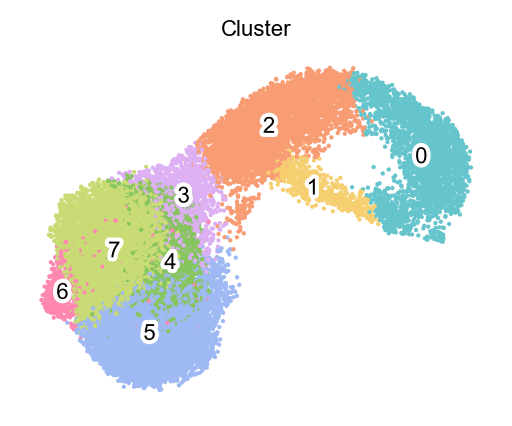

In [ ]:
margin_right = 0

fig_width = margin_left + plot_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v2,
    basis="X_umap",
    color="leiden",
    palette=leiden_colors,
    ax=axes,
    title="Cluster",
    legend_loc="on data",
    legend_fontsize="medium",
    legend_fontweight="normal",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

### Timepoint

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


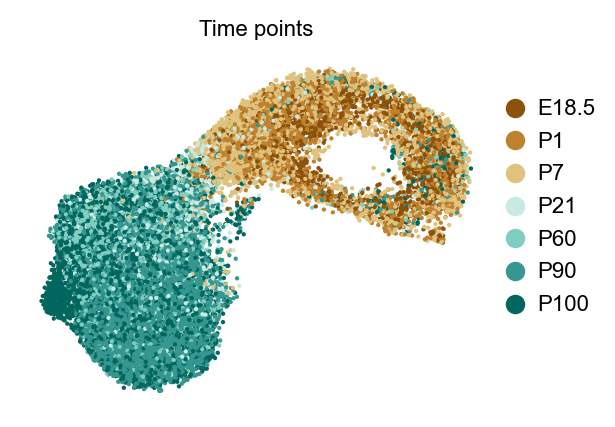

In [ ]:
margin_right = 20 / 25.4

fig_width = margin_left + plot_width_in + legend_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v2,
    basis="X_umap",
    color="timepoint",
    palette=timepoint_colors,
    ax=axes,
    title="Time points",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1 - (margin_right / fig_width), 0.5),
)

## Dotplots

<positron-console-cell-22>:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<positron-console-cell-22>:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
2025-09-04 09:47:26 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-04 09:47:26 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


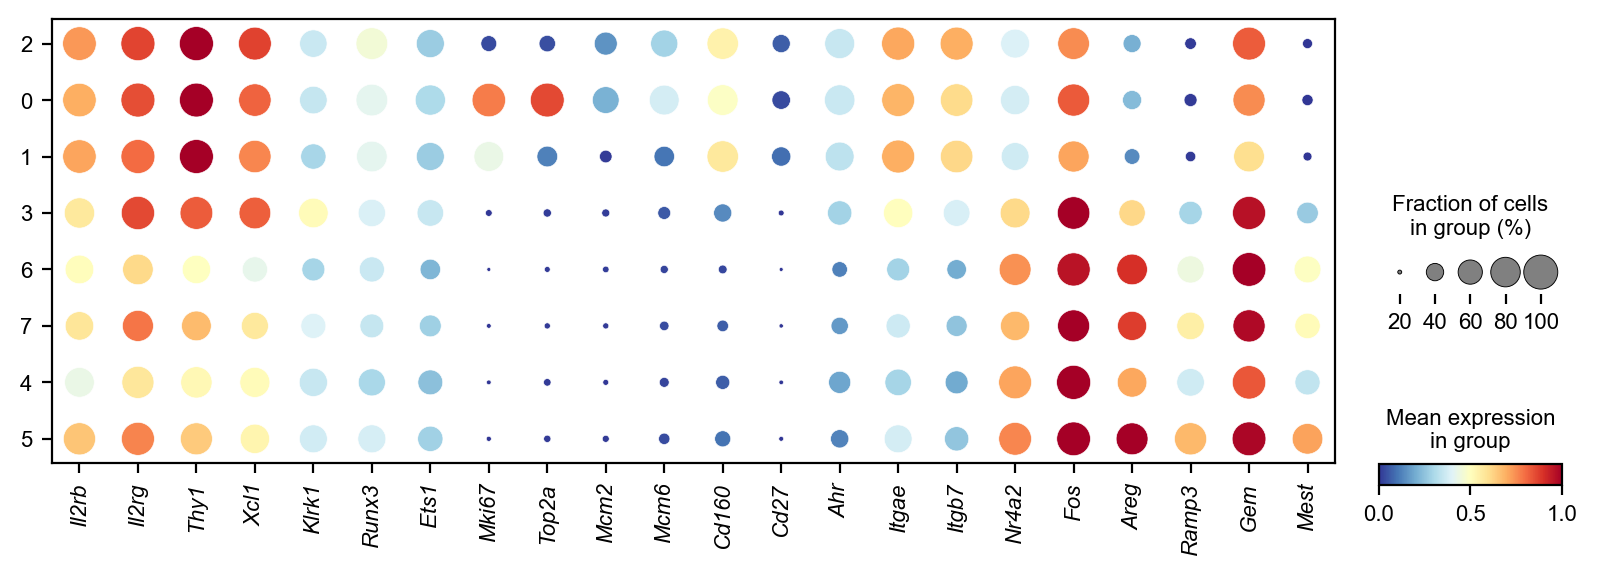

In [ ]:
genes = [
    "Il2rb",
    "Il2rg",
    "Thy1",
    "Xcl1",
    "Klrk1",
    "Runx3",
    "Ets1",
    "Mki67",
    "Top2a",
    "Mcm2",
    "Mcm6",
    "Cd160",
    "Cd27",
    "Ahr",
    "Itgae",
    "Itgb7",
    "Nr4a2",
    "Fos",
    "Areg",
    "Ramp3",
    "Gem",
    "Mest",
]

order_cluster = ["2", "0", "1", "3", "6", "7", "4", "5"]

fig, ax_dotplot = plot_dotplot(
    adata_cleaned_v2,
    genes=genes,
    groupby="leiden",
    categories_order=order_cluster,
    swap_axes=False,
    figsize=(199.902 / 25.4, 70 / 25.4),
    dot_sizes=(2, 150),
    legend_size=(1.2, 0.3),
    legend_wspace=0.05,
    margin_dotplot=(-0.025, 0.01),
)

## Boxplots Gene sets

In [31]:
df = sc.get.obs_df(adata_cleaned_v2, keys=["timepoint", "replicate"])

df = (
    df.merge(adata_cleaned_v2.obsm["score_aucell"], left_index=True, right_index=True)
    .groupby(["timepoint", "replicate"], observed=True)
    .mean()
    .reset_index()
)

<positron-console-cell-32>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-32>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-32>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-32>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


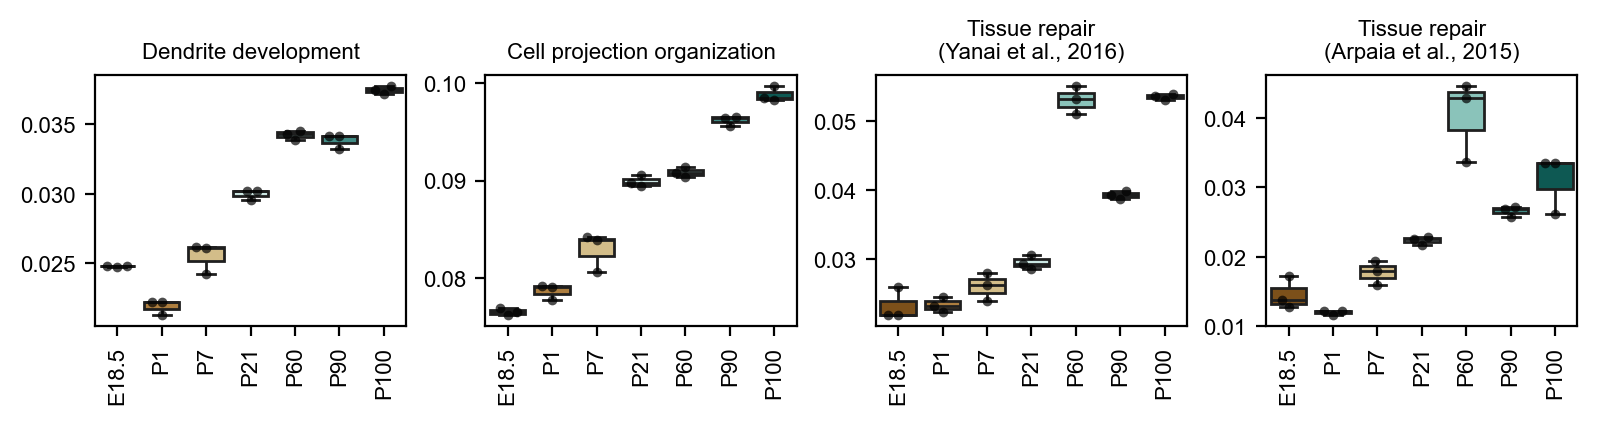

In [ ]:
gene_set_title = {
    "GOBP_DENDRITE_DEVELOPMENT": "Dendrite development",
    "GOBP_CELL_PROJECTION_ORGANIZATION": "Cell projection organization",
    "tissue_repair_yanai_2016": "Tissue repair\n(Yanai et al., 2016)",
    "tissue_repair_arpaia_2015": "Tissue repair\n(Arpaia et al., 2015)",
}

gene_sets_names = list(gene_set_title.keys())

n_col = min(len(gene_sets_names), 4)
n_row = int(np.ceil(len(gene_sets_names) / n_col))

fig = plt.figure(
    figsize=(((199.902 / 4) / 25.4) * n_col, 51 / 25.4 * n_row),
    dpi=200,
    layout="constrained",
)

for gene in gene_sets_names:
    ax = fig.add_subplot(n_row, n_col, gene_sets_names.index(gene) + 1)

    sns.boxplot(
        data=df, x="timepoint", y=gene, hue="timepoint", palette=timepoint_colors
    )

    sns.swarmplot(data=df, x="timepoint", y=gene, color="black", alpha=0.7, size=3.5)

    ax.set_title(
        gene_set_title[gene],
    )

    ax.set_xlabel("")

    if gene_sets_names.index(gene) == 0:
        ax.set_ylabel("AUCell score")
    else:
        ax.set_ylabel("")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Barplots

### cluster per timepoint

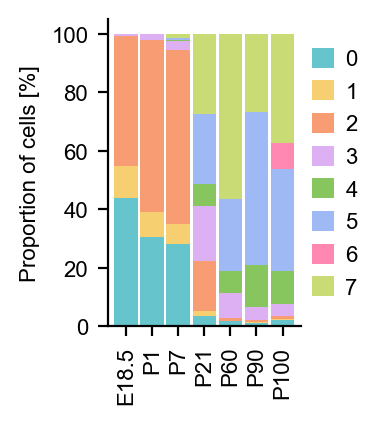

In [ ]:
fig, axes = plt.subplots(
    1, 1, figsize=(45 / 25.4, 51 / 25.4), dpi=200, layout="constrained"
)

p1 = get_dataframe_barplot(
    adata_cleaned_v2, groupby="timepoint", color_var="leiden", normalize_color_var=False
).plot(kind="bar", stacked=True, width=0.9, color=leiden_colors, ax=axes)

p1.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)

p1.set_xlabel("")
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
p1.set_ylabel(
    "Proportion of cells [%]",
)

p1.spines["right"].set_visible(False)
p1.spines["top"].set_visible(False)

# Saving

In [ ]:
# adata_cleaned_v2.write_h5ad(f"{data_path}detc_cleaned.h5ad")